In [1]:
%load_ext blackcellmagic
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = pd.read_sql("""Select * from measurement""", con=engine)
summary = pd.DataFrame.describe(df)
summary.head()

,id,prcp,tobs
count,19550.000000,18103.000000,19550.000000
mean,9775.500000,0.160644,73.097954
std,5643.743217,0.468746,4.523527
min,1.000000,0.000000,53.000000
25%,4888.250000,0.000000,70.000000


![describe](Images/describe.png)

In [11]:
# Design a query to show how many stations are available in this dataset?
cmd = session.query(func.count(Station.station))
session.commit()
pprint(cmd.all())

[(9,)]


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
cmd = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
session.commit()
pprint(cmd)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
cmd = session.query(
    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)
).all()
session.commit()
pprint(cmd)

[(53.0, 87.0, 73.09795396419437)]


In [14]:
# Choose the station with the highest number of temperature observations.
cmd = (
    session.query(Measurement.station, func.count(Measurement.tobs))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.tobs).desc())
    .first()
)
session.commit()
pprint(cmd)

('USC00519281', 2772)


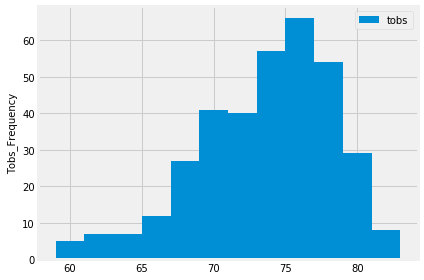

In [15]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_yr = (dt.date(2017,8,23) - dt.timedelta(days=366))
tobs_data = (
    session.query(Measurement.station, Measurement.tobs, Measurement.date)
    .filter(Measurement.station == "USC00519281").filter(Measurement.date >= last_yr)
    .all()
)

# session.commit()
tobs_df = pd.DataFrame(tobs_data)
plt.hist(tobs_df["tobs"], bins=12)
plt.ylabel("Tobs_Frequency", fontsize=10)
labels = ["tobs"]
plt.legend(labels)
plt.tight_layout()
plt.savefig("Frequency.png")
plt.show()
# pprint(tobs_df)


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip = calc_temps("2017-08-23", "2017-09-23")
trip_df = pd.DataFrame(trip, columns=["TMin", "TAvg", "TMax"])
pprint(trip_df)

   TMin   TAvg  TMax
0  76.0  80.25  82.0


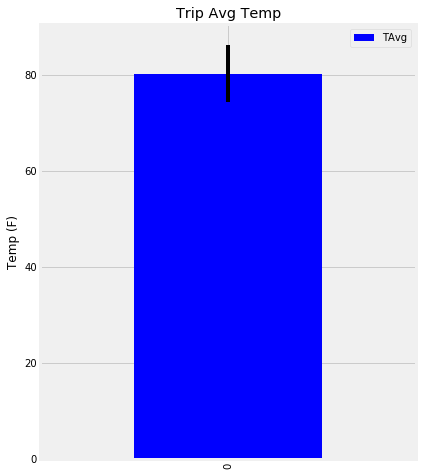

In [20]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df.plot.bar(
    title="Trip Avg Temp",
    y="TAvg",
    yerr=(trip_df["TMax"] - trip_df["TMin"]),
    color="blue",
    figsize=(6, 8),
)

plt.ylabel("Temp (F)")
plt.savefig("Avg_Temp.png")
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start, end):
    select = [
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        Measurement.prcp,
    ]
    cmd = (
        session.query(*select)
        .filter(Measurement.station == Station.station)
        .filter(Measurement.date >= start)
        .filter(Measurement.date <= end)
        .group_by(Measurement.station)
        .order_by(Measurement.prcp.desc())
        .all()
    )
    session.commit()
    return cmd


pprint(rainfall("2017-08-23", "2017-09-23"))

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.45),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]
